In [1]:
import os
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skimage
import torch
import tifffile
from einops import rearrange
from torchio.transforms import Resize

import napari

In [2]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [3]:
outputs = pickle.load(open(
    '/Users/erikstorrs/Downloads/mushroom_50res/outputs.pkl', 'rb'
))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [4]:
np.unique(outputs['dtype_to_volume']['integrated'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [3]:
directory = '/Users/erikstorrs/Downloads/export/HT413C1-Th1k4A1/'

In [31]:
outputs = pickle.load(open(
    os.path.join(directory, f'outputs.pkl'), 'rb'
))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [32]:
outputs['dtype_to_volume'].keys()

dict_keys(['cosmx', 'he', 'multiplex', 'xenium', 'integrated'])

In [33]:
# volume = outputs['dtype_to_volume']['xenium']
volume = outputs['dtype_to_volume']['integrated']
volume.shape

(42, 100, 76)

In [34]:
clusters = np.unique(volume)
clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [35]:
z_scaler = .5 # do an additional downsample on z
target = (volume.shape[2], volume.shape[1], int(volume.shape[0] * z_scaler))
# target = (int(volume.shape[2] / z_scaler), int(volume.shape[1] / z_scaler), volume.shape[0])
transform = Resize(target, label_interpolation='nearest')
volume = transform(rearrange(volume, 'n h w -> 1 w h n'))
volume = rearrange(volume, '1 w h n -> n h w')
volume.shape

(21, 100, 76)

In [36]:
volume = np.vstack((
    np.expand_dims(np.zeros_like(volume[0]), 0) - 1,
    volume,
    np.expand_dims(np.zeros_like(volume[0]), 0) - 1,
))

In [37]:
mapping = {}
cmap = {i:x if i not in mapping else np.asarray(mapping[i]) / 255.
        for i, x in enumerate(sns.color_palette('tab20'))}

In [38]:
# viewer = napari.Viewer(ndisplay=3, )
# for cluster in clusters:
#     viewer.add_labels(
#         (volume==cluster).astype(int), name=cluster, visible=False, opacity=1., color={1:cmap.get(cluster, (1.,1.,1.))}, num_colors=1, )

# state = viewer.window.qt_viewer.view.camera.get_state()
# q = state['_quaternion']
# q.w = -0.1342043174741573
# q.x = -0.9830775909136398
# q.y = 0.020420481999648066
# q.z = 0.12300672879819263
# viewer.window.qt_viewer.view.camera.set_state(state)

In [103]:
keep = [
#     22, 23, 24, 25, 26, 12
#     35, 22, 33, 25, 8, 10, 11, 12, 26, 23, 24
#     6,5,4,3,2,1,0
    5,4,6,0,12
]
mask = np.zeros_like(volume)
for k in keep:
    mask[volume==k] = True
mask.shape

(23, 100, 76)

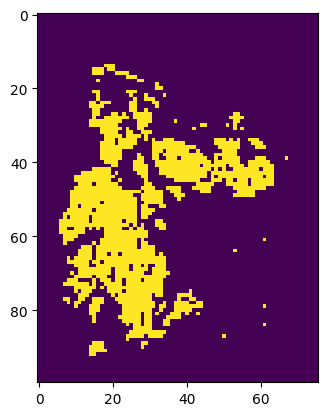

In [104]:
plt.imshow(mask[2])

In [105]:
import scipy
# mask = scipy.ndimage.gaussian_filter(mask, sigma=.14)

In [106]:
mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

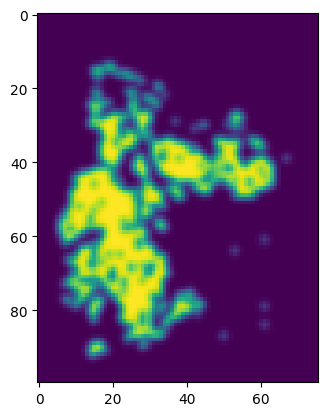

In [107]:
mask = skimage.filters.gaussian(mask, sigma=1., channel_axis=0)
plt.imshow(mask[2])

In [108]:
mask.max()

1.0841865043192904e-19

In [109]:
mask.shape

(23, 100, 76)

In [110]:
verts, faces, normals, values = skimage.measure.marching_cubes(mask, level=mask.max() * .5)

In [111]:
# flat_spot = napari.layers.Surface(
#     (verts, faces, np.random.random((3, 3, len(verts)))),
#     colormap="plasma",
    
# #     translate=(1, 0, 0),
# #     texture=texture,
# #     texcoords=texcoords,
# #     shading="flat",
# #     name="texture only",
# )

# viewer = napari.Viewer(ndisplay=3)
# viewer.add_layer(flat_spot)

In [112]:
verts

array([[ 0.50005764, 14.        , 19.        ],
       [ 1.        , 14.        , 18.500004  ],
       [ 1.        , 13.500027  , 19.        ],
       ...,
       [21.499952  , 83.        , 21.        ],
       [21.499947  , 83.        , 22.        ],
       [21.499939  , 83.        , 23.        ]], dtype=float32)

In [113]:
idx = 0
# gv = tifffile.imread('/Users/erikstorrs/Downloads/test.tif')
# gv = tifffile.imread('/Users/erikstorrs/Downloads/ht413_cell_type_vol.tif')
gv = tifffile.imread('/Users/erikstorrs/Downloads/ht413_fn1_vol.tif')
# gv = gv[idx]
gv.shape

(1, 42, 100, 76)

In [114]:
# gv = gv / (gv.sum(0) + 1)

In [115]:
gv.max()

47.21742155870446

In [116]:
gv = gv[idx]

In [117]:
z_scaler = .5 # do an additional downsample on z
target = (gv.shape[2], gv.shape[1], int(gv.shape[0] * z_scaler))
transform = Resize(target)
gv = transform(rearrange(gv, 'n h w -> 1 w h n'))
gv = rearrange(gv, '1 w h n -> n h w')
gv.shape

(21, 100, 76)

In [118]:
gv = np.concatenate((
    gv[:1],
    gv,
    gv[-1:]
), axis=0)
# gv = np.concatenate((
#     np.zeros((1, gv.shape[1], gv.shape[2]), dtype=int),
#     gv,
#     np.zeros((1, gv.shape[1], gv.shape[2]), dtype=int),
# ), axis=0)
gv.shape

(23, 100, 76)

In [119]:
# k1, k2, k3 = [np.array([1,1,1]) for i in range(3)]

# for i, k in enumerate((k1, k2, k3)):
#     gv = scipy.ndimage.convolve1d(gv, k, axis=i)
# gv.shape

In [120]:
m = np.zeros_like(volume)
for k in keep:
    m[volume==k] = True
m.shape

(23, 100, 76)

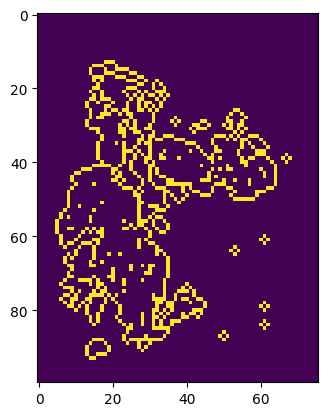

In [121]:
plt.imshow(m[1])
plt.imshow(skimage.morphology.binary_dilation(m[1]) - m[1])

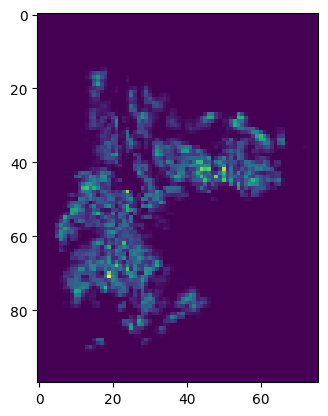

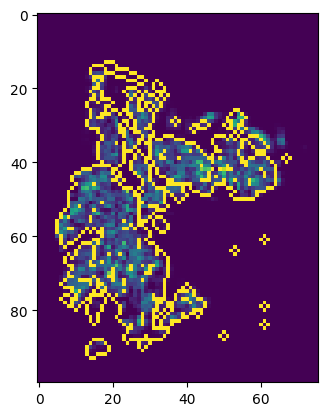

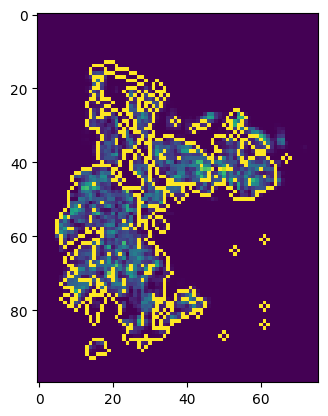

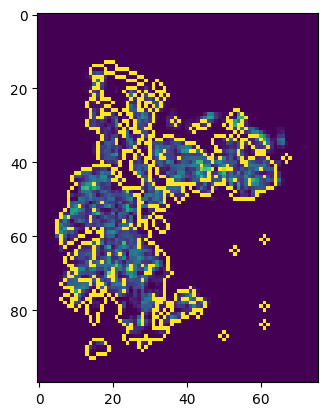

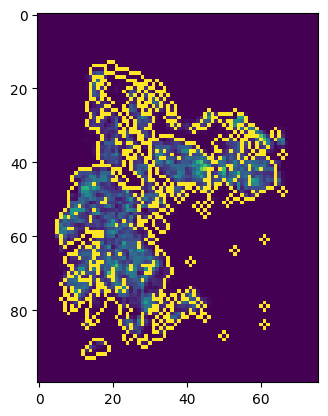

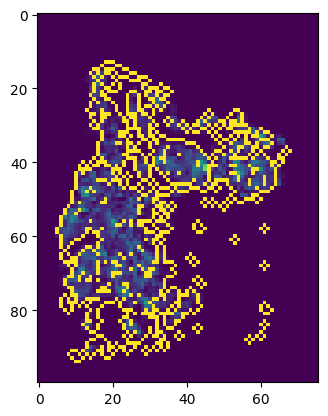

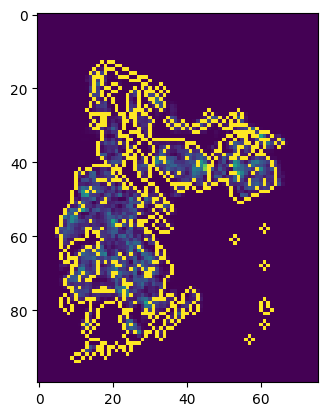

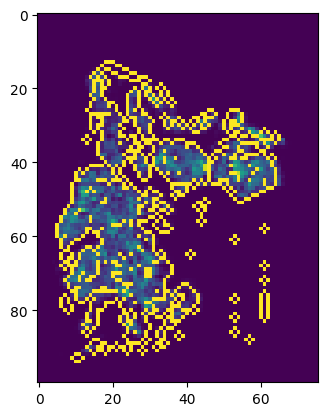

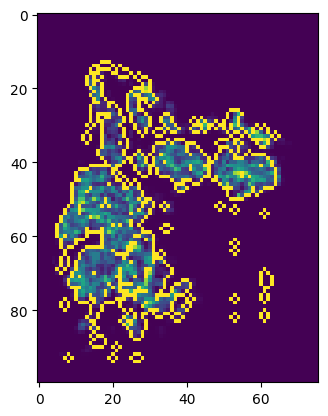

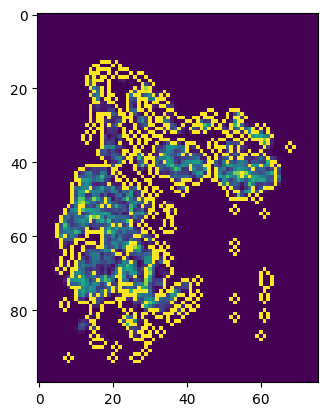

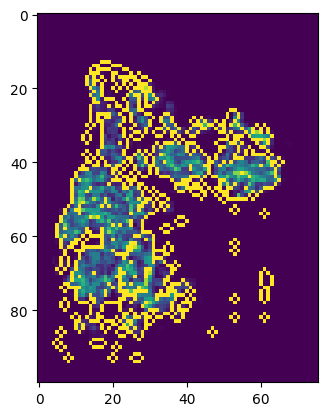

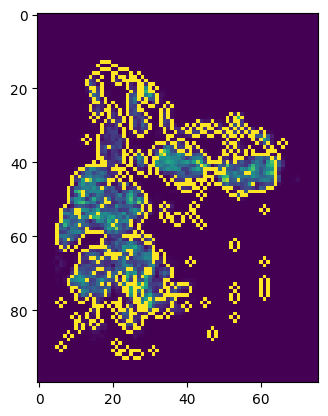

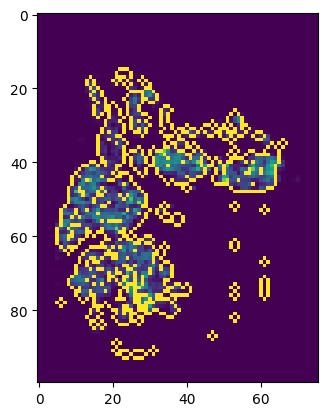

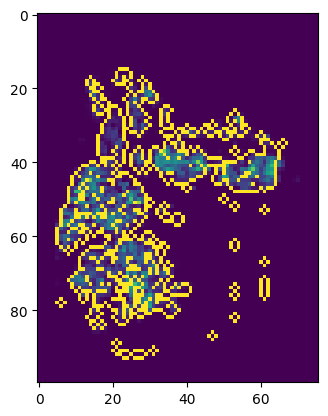

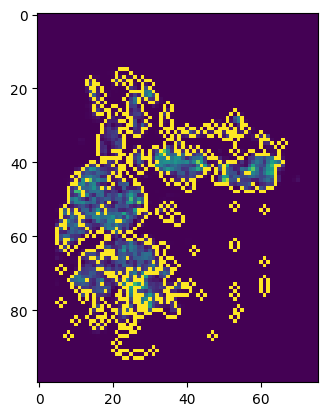

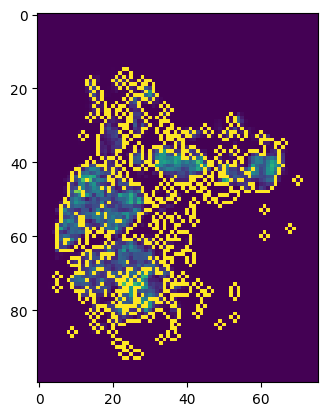

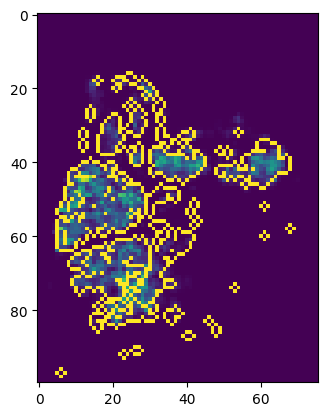

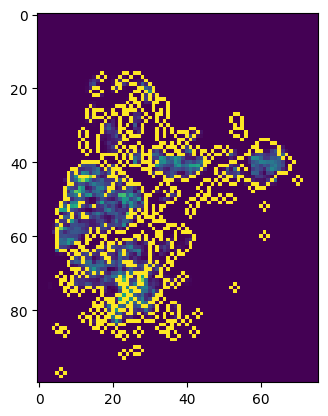

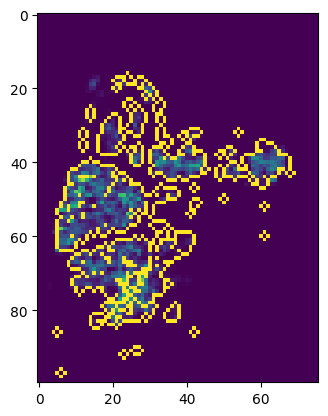

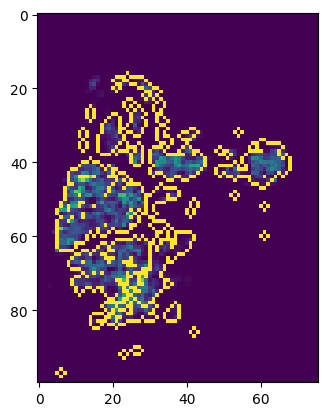

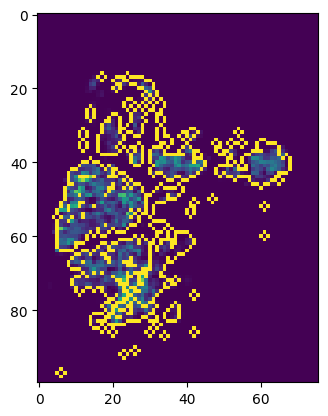

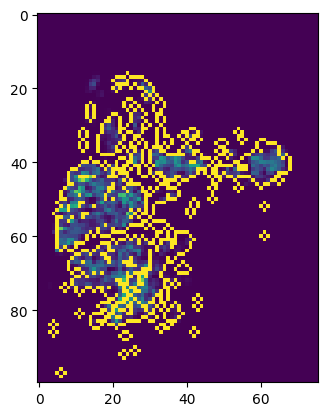

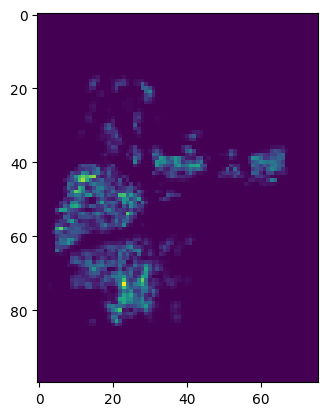

In [122]:
# fig, axs = plt.subplots(nrows=len(gv), ncols=2)
for i, (x, tumor) in enumerate(zip(gv, m)):
    boundary = skimage.morphology.binary_dilation(tumor) - tumor
    new = x.copy()
    new[boundary>0] = x.max()
    plt.imshow(new)
    plt.show()

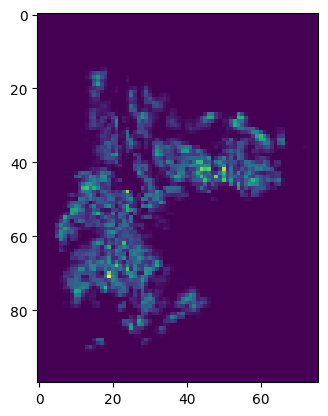

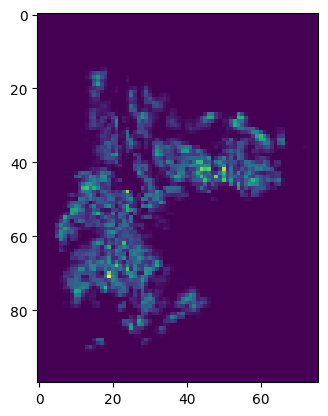

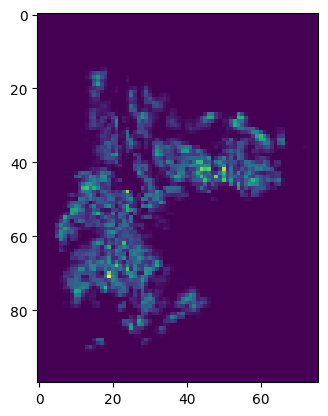

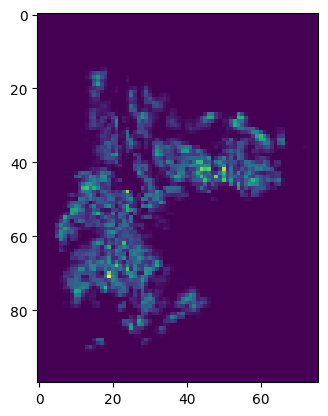

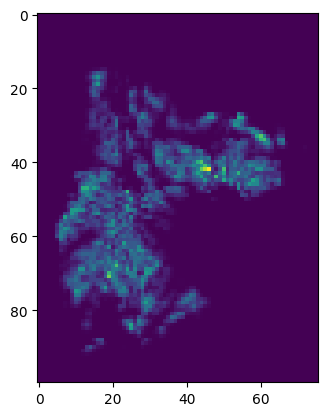

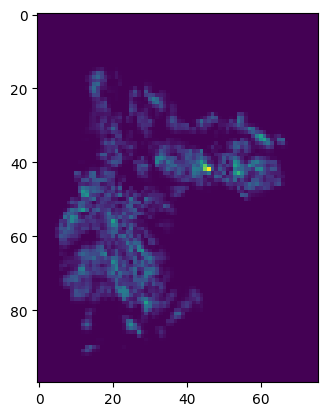

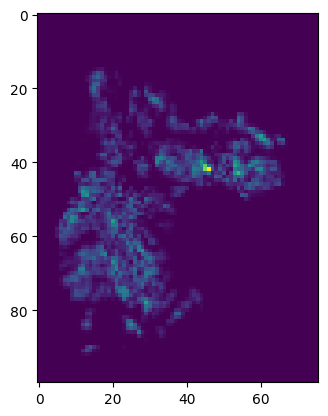

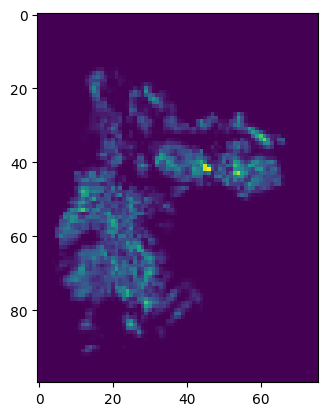

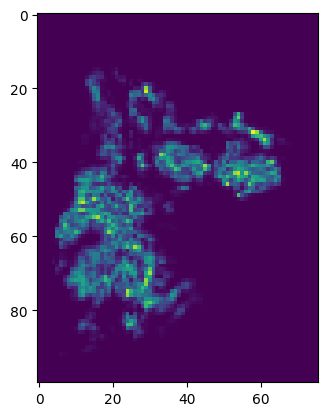

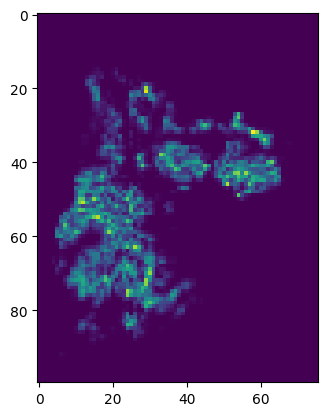

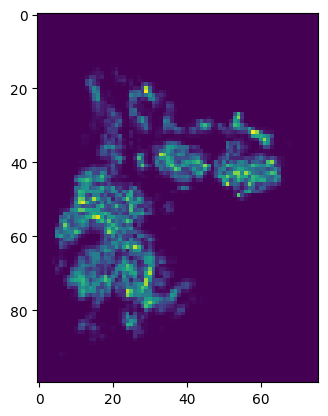

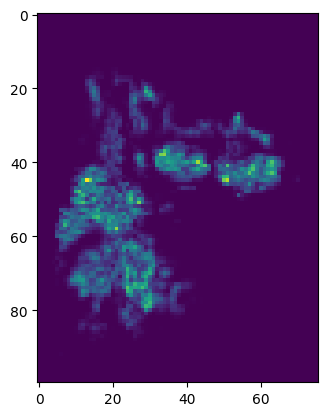

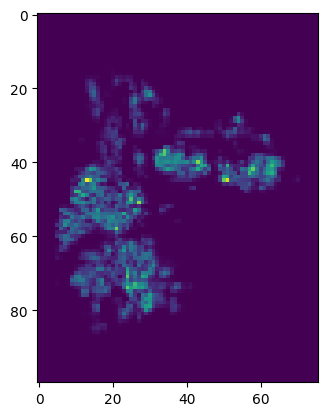

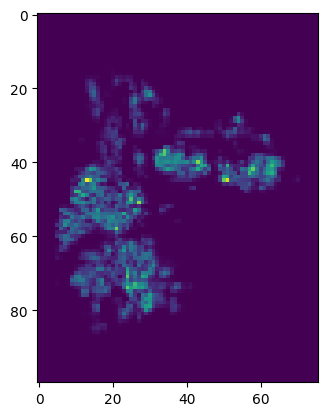

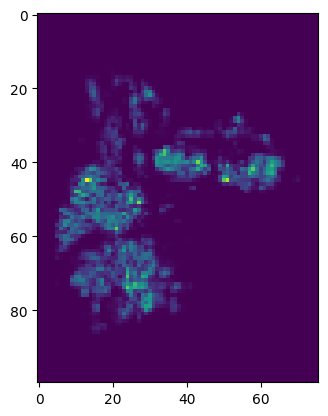

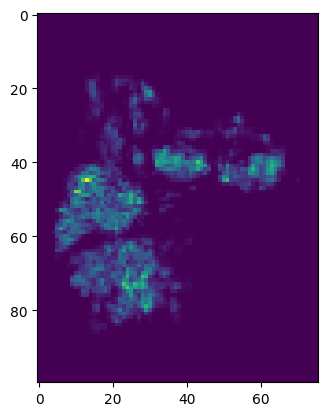

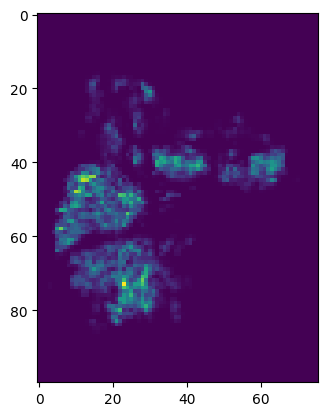

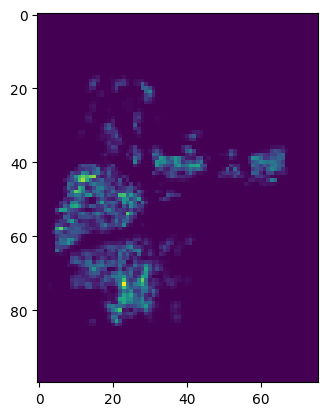

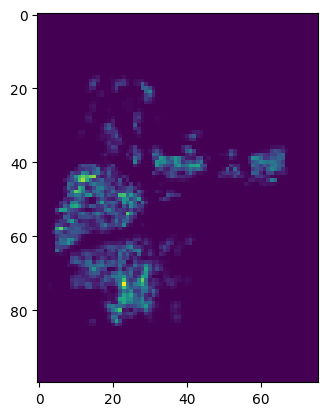

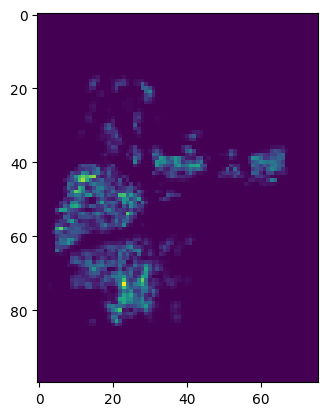

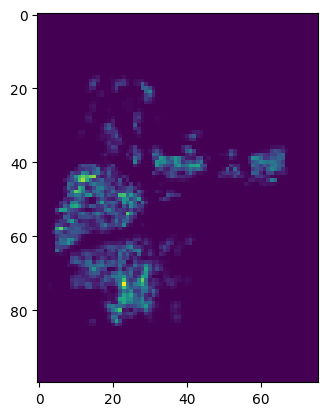

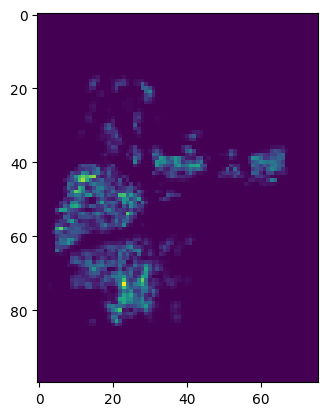

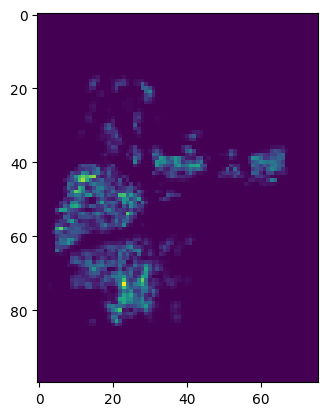

In [123]:
for x in gv:
    plt.imshow(x)
    plt.show()

In [124]:
vert_coords = verts.astype(int)
vert_coords

array([[ 0, 14, 19],
       [ 1, 14, 18],
       [ 1, 13, 19],
       ...,
       [21, 83, 21],
       [21, 83, 22],
       [21, 83, 23]])

In [125]:
vals = gv[vert_coords[:, 0], vert_coords[:, 1], vert_coords[:, 2]]
vals

array([ 0.        ,  0.        ,  0.        , ..., 16.99607794,
        6.86456225,  0.62436741])

In [129]:
flat_spot = napari.layers.Surface(
    (verts, faces, vals),
    colormap="plasma",
    shading='smooth',
#     vertex_values=vals
    
#     translate=(1, 0, 0),
#     texture=texture,
#     texcoords=texcoords,
#     shading="flat",
#     name="texture only",
)

viewer = napari.Viewer(ndisplay=3)
viewer.add_layer(flat_spot)

<Surface layer 'Surface' at 0x310a016d0>

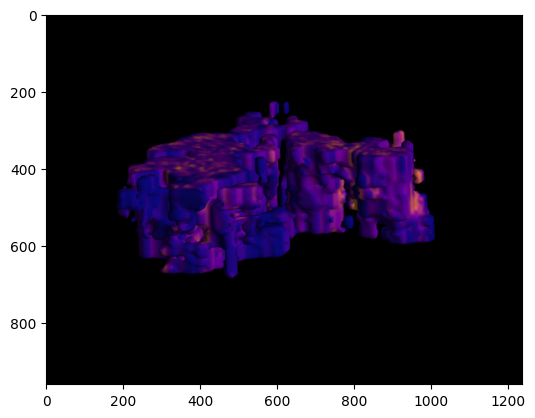

In [149]:
screenshot = viewer.screenshot()
mask = screenshot[..., :-1].sum(axis=-1) == 0
plt.imshow(screenshot)

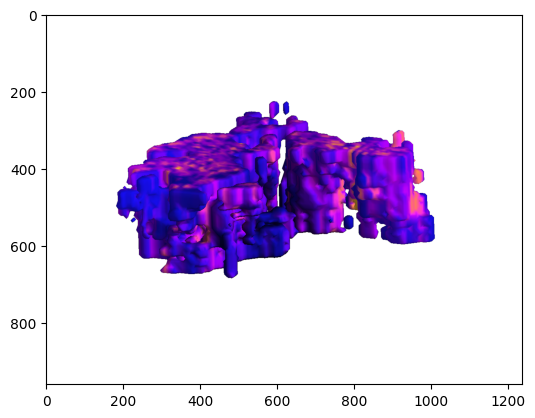

In [150]:
# need to adjust saturation to match viewer
# screenshot = skimage.exposure.equalize_adapthist(screenshot, kernel_size=None, clip_limit=0.15, nbins=256)
screenshot = skimage.exposure.equalize_adapthist(screenshot, kernel_size=400, clip_limit=0.0, nbins=256)

screenshot *= 255
screenshot = screenshot.astype(np.uint8)

screenshot = np.concatenate(
    (screenshot, np.full((screenshot.shape[0], screenshot.shape[1], 1), 255, dtype=np.uint8)), axis=-1)
screenshot[mask, -1] = 0.
plt.imshow(screenshot)

In [151]:
skimage.io.imsave(f'/Users/erikstorrs/Downloads/volume.png', screenshot)

In [511]:
gv.max()

21.692251447621686

In [197]:
keep = [
#     22, 23, 24, 25, 26, 12
#     35, 22, 33, 25, 8, 10, 11, 12, 26, 23, 24
    6,5,4,3,2,1,0
]
mask = np.zeros_like(volume)
for k in keep:
    mask[volume==k] = True
mask.shape

(21, 100, 76)

In [198]:
mask = skimage.filters.gaussian(mask, sigma=1., channel_axis=0)

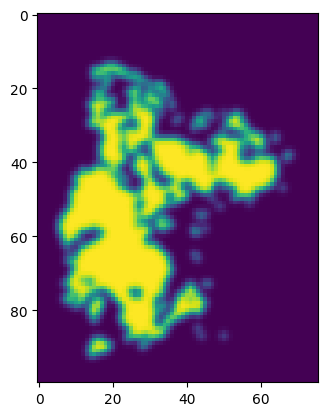

In [199]:
plt.imshow(mask[0])

In [200]:
mask.min(), mask.max()

(0.0, 1.0842021724855044e-19)

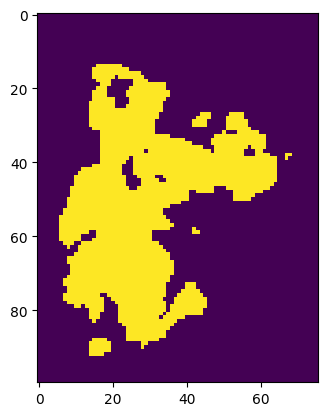

In [201]:
thresh = mask.max() * .3
plt.imshow(mask[0] > thresh)

In [202]:
mask = mask > thresh 

In [203]:
v = gv.copy()
v.shape

(21, 100, 76)

In [204]:
np.linspace(v.min(), v.max(), n)

array([-0.46716955,  0.31178173,  1.09073301,  1.86968429,  2.64863558,
        3.42758686,  4.20653814,  4.98548942,  5.76444071,  6.54339199,
        7.32234327,  8.10129456,  8.88024584,  9.65919712, 10.4381484 ,
       11.21709969, 11.99605097, 12.77500225, 13.55395353, 14.33290482])

In [205]:
n = 20
quantized = np.digitize(v, np.linspace(v.min(), v.max() // 2, n))
labels, counts = np.unique(quantized, return_counts=True)
labels, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 array([71650, 68124,  5799,  5030,  2907,  2130,  1212,   851,   452,
          330,   240,   181,   147,   106,    86,    65,    55,    46,
           41,   148]))

In [206]:
cmap = sns.color_palette('plasma', n_colors=len(labels))
cmap

[(0.16407, 0.020171, 0.577478),
 (0.248032, 0.014439, 0.612868),
 (0.32515, 0.006915, 0.639512),
 (0.399411, 0.000859, 0.656133),
 (0.471457, 0.005678, 0.659897),
 (0.546157, 0.038954, 0.64701),
 (0.610667, 0.090204, 0.619951),
 (0.669845, 0.142992, 0.582154),
 (0.723444, 0.196158, 0.538981),
 (0.771958, 0.249237, 0.494813),
 (0.819651, 0.306812, 0.448306),
 (0.85975, 0.360588, 0.406917),
 (0.896131, 0.415712, 0.366407),
 (0.928329, 0.472975, 0.326067),
 (0.95547, 0.533093, 0.28549),
 (0.977856, 0.602051, 0.241387),
 (0.990681, 0.669558, 0.201642),
 (0.994495, 0.74088, 0.166335),
 (0.987621, 0.815978, 0.144363),
 (0.968443, 0.894564, 0.147014)]

In [207]:
cmap = {i:x for i, x in enumerate(cmap)}

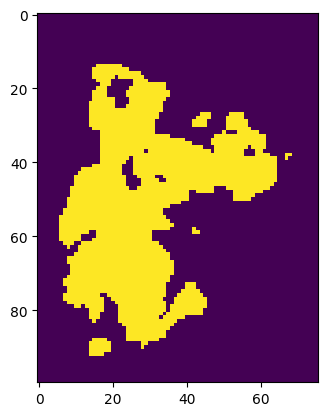

In [208]:
plt.imshow(mask[0])

In [209]:
quantized[~mask] = quantized.min()

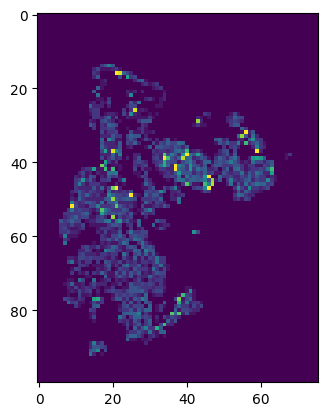

In [210]:
plt.imshow(quantized[0])

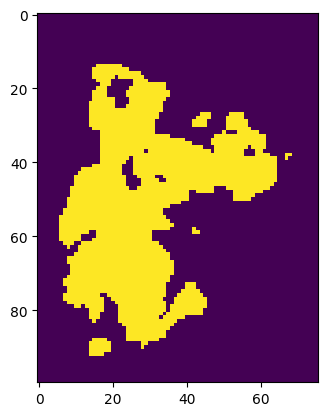

In [211]:
plt.imshow(mask[0])

In [212]:
viewer = napari.Viewer(ndisplay=3, )
for cluster in labels:
    viewer.add_labels(
        (quantized==cluster).astype(int), name=cluster, visible=True, opacity=1., color={1:cmap.get(cluster, (1.,1.,1.))}, num_colors=1, )

state = viewer.window.qt_viewer.view.camera.get_state()
q = state['_quaternion']
q.w = -0.1342043174741573
q.x = -0.9830775909136398
q.y = 0.020420481999648066
q.z = 0.12300672879819263
viewer.window.qt_viewer.view.camera.set_state(state)

/var/folders/l4/tr_3w7sx31z58xhsnb0_07hw0000gr/T/ipykernel_40005/4052538435.py:6: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  state = viewer.window.qt_viewer.view.camera.get_state()
/var/folders/l4/tr_3w7sx31z58xhsnb0_07hw0000gr/T/ipykernel_40005/4052538435.py:12: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  viewer.window.qt_viewer.view.camera.set_state(state)
